In [2]:
from graphviz import Source
from matplotlib import pyplot as plt
from monty.serialization import loadfn
import pandas as pd
from pymatgen.core.periodic_table import Element
import pymatgen as mg
from pymatgen.analysis.local_env import CrystalNN
import networkx as nx
import numpy as np
import pydot

In [3]:
# List of electronegative elements specified in M. O'Keefe, & N. Brese,
# JACS, 1991, 113(9), 3226-3229. doi:10.1021/ja00009a002.
ELECTRONEG = [Element(sym) for sym in ["H", "B", "C", "Si",
                                       "N", "P", "As", "Sb",
                                       "O", "S", "Se", "Te",
                                       "F", "Cl", "Br", "I"]]

# Read in BV parameters.
BV_PARAMS = {}
# for k, v in loadfn('/home/nicholas/CODE/miniconda3/lib/python3.6/site-packages/pymatgen/analysis/bvparam_1991.yaml').items():
for k, v in loadfn('C:\\Users\\Nick\\Anaconda3\\Lib\\site-packages\\pymatgen\\analysis\\bvparam_1991.yaml').items():
    BV_PARAMS[Element(k)] = v

In [4]:
class Graph:
    def __init__(self, struct, attr='dist'):
        self.G = nx.MultiGraph()
        self.struct = struct
        self.attr = attr
        self.nn = CrystalNN()
        self.visited = []

        self.names, self.counter = {}, {}
        sga = mg.symmetry.analyzer.SpacegroupAnalyzer(self.struct)
        
        for i, site in enumerate(self.struct):
            elem = site.as_dict()['species'][0]['element']
            if elem not in self.counter.keys():
                num = 1
                self.counter[elem] = 1
            else:
                num = self.counter[elem] + 1
                self.counter[elem] += 1
            if num < 10:
                node_name = elem + '0' + str(num)
            else:
                node_name = elem + str(num)
            self.names[i] = node_name
    def add_edges(self, index, site):
        
        node_name = self.names[index]
        neighbors = self.nn.get_nn_info(struct, index)
        for neighbor in neighbors:        
            if neighbor['site_index'] in self.visited:
                continue
            else:
                neigh_name = self.names[neighbor['site_index']]
                dist = neighbor['site'].distance(struct[index])
                if self.attr == 'distance':
                    self.G.add_edge(node_name, neigh_name,distance=dist)
                elif self.attr == 'bv': 
                    bv = self.calc_vij(struct[index], neighbor, dist)
                    self.G.add_edge(node_name, neigh_name,label='{:.2f}'.format(bv))
                    
        self.visited.append(index)
    def calc_vij(self, site, neighbor, distance):
        scale_factor = 1 # Change if distance needs to be scaled such as for underbound (GGA) or overbound (LDA) calculated structures
        el1 = Element(site.as_dict()['species'][0]['element'])
        el2 = Element(struct[neighbor['site_index']].as_dict()['species'][0]['element'])
        if (el1 in ELECTRONEG or el2 in ELECTRONEG) and el1 != el2:
            r1 = BV_PARAMS[el1]["r"]
            r2 = BV_PARAMS[el2]["r"]
            c1 = BV_PARAMS[el1]["c"]
            c2 = BV_PARAMS[el2]["c"]
            R = r1 + r2 - r1 * r2 * (np.sqrt(c1) - np.sqrt(c2)) ** 2 / \
                (c1 * r1 + c2 * r2)
            vij = np.exp((R - distance * scale_factor) / 0.31)
            return vij
    def calc_bv_sum(self, index):
        bvsum = 0
        for edge in self.G[self.names[index]].values():
            for unique in edge.values():
                bvsum += np.abs(np.float(unique['label']))
        bvsum = '{:.2f}'.format(bvsum)
        return bvsum
    def build_graph(self):
        for index,site in enumerate(self.struct):
            self.add_edges(index, site)
            self.G.nodes[self.names[index]]['xlabel'] = self.calc_bv_sum(index) 
    def plot_graph(self):
        nx.draw(self.G, with_labels=True, font_weight='bold')
        plt.show()

In [7]:
# Change filename to your desired structure's filename
filename = 'Nb_R3c.vasp'
with open("../data/{}".format(filename)) as f:
    lines = f.read()
    if filename[-1]=='f':
        struct = mg.Structure.from_str(lines, fmt='CIF')
    elif filename[-1] =='p':
        struct = mg.Structure.from_str(lines, fmt='POSCAR')
goo = Graph(struct, attr='bv')
goo.build_graph()
nx.write_gml(goo.G, path='../data/{}_graph.gml'.format(filename))

In [6]:
list(goo.G.edges)

[('Mo01', 'N01', 0),
 ('Mo01', 'N04', 0),
 ('Mo01', 'N04', 1),
 ('N01', 'Mo03', 0),
 ('N01', 'Mo04', 0),
 ('N01', 'Mo04', 1),
 ('N01', 'Mo06', 0),
 ('N01', 'Mo06', 1),
 ('N04', 'Mo06', 0),
 ('N04', 'Mo07', 0),
 ('N04', 'Mo07', 1),
 ('N04', 'Mo08', 0),
 ('Mo02', 'N02', 0),
 ('Mo02', 'N03', 0),
 ('Mo02', 'N03', 1),
 ('N02', 'Mo03', 0),
 ('N02', 'Mo03', 1),
 ('N02', 'Mo04', 0),
 ('N02', 'Mo05', 0),
 ('N02', 'Mo05', 1),
 ('N03', 'Mo05', 0),
 ('N03', 'Mo07', 0),
 ('N03', 'Mo08', 0),
 ('N03', 'Mo08', 1)]

In [13]:
struct

Structure Summary
Lattice
    abc : 4.14 4.14 8.805
 angles : 90.0 90.0 90.0
 volume : 150.91417799999996
      A : 4.14 0.0 2.5350188742350207e-16
      B : 6.657627769661275e-16 4.14 2.5350188742350207e-16
      C : 0.0 0.0 8.805
PeriodicSite: Ti0+ (2.0700, 3.1050, 0.9686) [0.5000, 0.7500, 0.1100]
PeriodicSite: Ti0+ (0.0000, 3.1050, 7.5723) [0.0000, 0.7500, 0.8600]
PeriodicSite: Ti0+ (2.0700, 1.0350, 7.8365) [0.5000, 0.2500, 0.8900]
PeriodicSite: Ti0+ (0.0000, 1.0350, 1.2327) [0.0000, 0.2500, 0.1400]
PeriodicSite: Ti0+ (0.0000, 1.0350, 5.3710) [0.0000, 0.2500, 0.6100]
PeriodicSite: Ti0+ (2.0700, 1.0350, 3.1698) [0.5000, 0.2500, 0.3600]
PeriodicSite: Ti0+ (0.0000, 3.1050, 3.4339) [0.0000, 0.7500, 0.3900]
PeriodicSite: Ti0+ (2.0700, 3.1050, 5.6352) [0.5000, 0.7500, 0.6400]
PeriodicSite: N0+ (2.0700, 3.1050, 7.7044) [0.5000, 0.7500, 0.8750]
PeriodicSite: N0+ (0.0000, 3.1050, 5.5031) [0.0000, 0.7500, 0.6250]
PeriodicSite: N0+ (2.0700, 1.0350, 1.1006) [0.5000, 0.2500, 0.1250]
PeriodicSite

In [8]:
goo.G['N01']

AdjacencyView({'Mo01': {0: {'label': '0.89'}}, 'Mo03': {0: {'label': '0.89'}}, 'Mo04': {0: {'label': '0.79'}, 1: {'label': '0.79'}}, 'Mo06': {0: {'label': '0.79'}, 1: {'label': '0.79'}}})

In [33]:
nx.drawing.nx_pydot.write_dot(goo.G, "../plots/{}_graph.dot".format(filename))

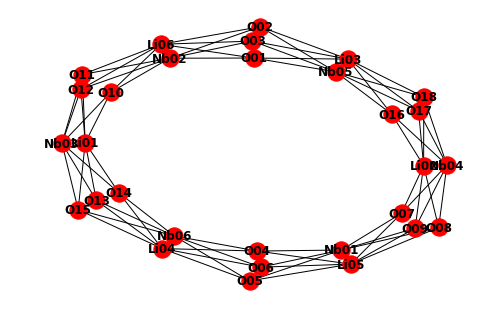

In [34]:
goo.plot_graph()

In [35]:
src = Source.from_file("../plots/{}_graph.dot".format(filename))
src.render('../plots/{}_graph.dot'.format(filename), view=True)

'../plots/Nb_R3c_graph.dot.pdf'